# Analysis of ROS model incorporating structural information

## Load libraries

In [1]:
import cobra
import pandas as pd

## Load model

In [2]:
ROS_model=cobra.io.read_sbml_model("ros_model.xml")

## Constraint ROS model

In [3]:

from cobra.flux_analysis import flux_variability_analysis

def constrain_model_by_ROS_and_SF(
    model,
    fdict,
    carbon_source_rxn="EX_glc__D_e",
    ROS_rxn="DM_h2o2_c",
    rango=(0.02, 3.0),
    reactions_to_constrain=None,
    carbon_uptake=-6.3,
    fraction_of_optimum=0.9
):
    """
    Constrains a GEM based on ROS production using FBA and FVA.

    Parameters
    ----------
    model : cobra.Model
        Genome-scale metabolic model (GEM).

    carbon_source_rxn : str
        Reaction ID of the carbon source exchange (e.g. 'EX_glc__D_e').

    ROS_rxn : str, optional
        Reaction ID of the target product exchange reaction to be maximized
        during FBA (default is 'EX_ROS_e').

    rango : tuple(float, float)
        Expected flux range (min, max) for pepito production.
        Values below the minimum are mapped to 0.2, values above the maximum
        are mapped to 0.8, and intermediate values are linearly scaled.

    reactions_to_constrain : list of str
        List of reaction IDs whose flux bounds will be constrained
        based on normalized pepito production and FVA results.

    carbon_uptake : float, optional
        Lower bound for carbon source uptake (negative value for uptake,
        default is -10.0).

    Returns
    -------
    dict
        Dictionary containing:
        - 'model' : cobra.Model
            Constrained model.
        - 'ROS_flux' : float
            Optimal pepito flux obtained from FBA.
        - 'normalized_value' : float
            Normalized value between 0.2 and 0.8.
        - 'fva' : pandas.DataFrame
            Flux Variability Analysis results for the constrained reactions.
    """

    if reactions_to_constrain is None:
        raise ValueError("Suply reactions related with ROS")

    model_cons = model.copy()

    # 1. Define carbon source
    # Delete default source
    model_cons.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
    model_cons.reactions.get_by_id(carbon_source_rxn).lower_bound = carbon_uptake

    # 2. FBA maximizing ROS
    #model_cons.objective = ROS_rxn #EVALUAR SI OPTIMIZACION O NO
    sol = model_cons.optimize()

    ROS_flux = sol.fluxes[ROS_rxn]  # Get total flux of ROS

    # 3. Normalization
    rmin, rmax = rango

    f_ros = max(0.6, 1 - (ROS_flux - rmin) * (1 - 0.66 / (rmax - rmin)))

    # 4. FVA
    fva_res = flux_variability_analysis(
        model_cons,
        reaction_list=reactions_to_constrain,
        fraction_of_optimum=fraction_of_optimum
    )

    # 5. Inhibimos las reacciones el porcentaje calculado
    for rxn_id in reactions_to_constrain:
        rxn = model_cons.reactions.get_by_id(rxn_id)

        fva_min = fva_res.loc[rxn_id, "minimum"]
        fva_max = fva_res.loc[rxn_id, "maximum"]

        structural_norm_value = fdict[rxn_id][0] * fdict[rxn_id][1]
        f_struct = max(0.3, structural_norm_value)

        f_total = f_struct * f_ros
        print(f_total)

        rxn.lower_bound = fva_min * f_total
        rxn.upper_bound = fva_max * f_total

        sol = model.optimize()
        if sol.status != "optimal":
            print("Breaks viability:", rxn_id)
            
    return {
        "model": model_cons,
        "ROS_flux": ROS_flux,
        "normalized_value": f_total,
        "fva": fva_res
    }


In [4]:
ROS_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002594,0,0.00%
cl_e,EX_cl_e,0.002594,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001866,0,0.00%
cu2_e,EX_cu2_e,0.001729,0,0.00%
fe2_e,EX_fe2_e,0.009015,0,0.00%
glc__D_e,EX_glc__D_e,6.3,0,0.00%
k_e,EX_k_e,0.0973,0,0.00%
mg2_e,EX_mg2_e,0.004324,0,0.00%
mn2_e,EX_mn2_e,0.001729,0,0.00%
mobd_e,EX_mobd_e,0.002003,0,0.00%


In [5]:
# Get list of susceptible reactions to constrain in the model
ROS_data = pd.read_csv('/home/jorgexd/ROS/All_susceptible.txt', sep = '\t', encoding = 'latin1')
ROS_data.head()


,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0808,Q88PP0,hmp,Flavohemoprotein,1,4.51,0,8,5.11,0,0,0.0,heme b (C34H30FeN4O4),S_Nitrogen_Metabolism,BRENDA,Bovine,1.14.12.17,Oxidoreductases,NaN,NaN
1,PP_5228,Q88CF3,dapF,Diaminopimelate epimerase,2,6.14,2,4,4.72,0,0,0.0,NaN,S_Lysine_Metabolism,When CgDapF was treated with various concentra...,Corynebacterium glutamicum,5.1.1.7,Isomerases,NaN,NaN
2,PP_0415,Q88QS3,rpe,Ribulose-phosphate 3-epimerase,0,5.13,0,2,5.95,0,0,0.0,Co(2+) (Co) AND Fe(2+) (Fe) AND Mn(2+) (Mn) AN...,S_Pentose_Phosphate_Pathway,"Easily affected by ROS, although this effect c...",E.coli,5.1.3.1,Isomerases,NaN,NaN
3,PP_2112,Q88L24,acnA-I,Aconitate hydratase,0,0.00,0,0,0.00,0,0,0.0,[4Fe-4S] cluster (Fe4S4),S_TCA_Cycle,"Upon ROS exposure, mitoNEET [2Fe-2S] cluster ...","E.coli, Human",4.2.1.3,Lyases,NaN,Rattus rattus AND Rattus norvegicus
4,PP_2336,Q88KF4,acnA-II,aconitate hydratase,0,0.00,0,0,0.00,0,0,0.0,[4Fe-4S] cluster (Fe4S4),S_Alternate_Carbon__Propanoate_Metabolism,Aconitase is sensitive to superoxide; see Gard...,"E.coli, Human",4.2.1.3,Lyases,NaN,Rattus rattus AND Rattus norvegicus


In [6]:
susceptible_enz = ROS_data["KEGG ID"].tolist()

In [7]:
# Get only those reactions having all its enzymes affected
import re


ROS_reactions_list = []
pattern = r'PP_\d{4}'

reactions_gpr = {}
for rxn in ROS_model.reactions:
    matches = re.findall(pattern, str(rxn.gpr))
    if matches:
        reactions_gpr[rxn.id] = matches

for reaction, gprs in reactions_gpr.items():
    if set(gprs).issubset(set(susceptible_enz)):
        ROS_reactions_list.append(reaction)
        print(f'\nReaction {reaction} is inhibited by ROS')
        print(ROS_model.reactions.get_by_id(reaction))


Reaction 34HPPOR is inhibited by ROS
34HPPOR: 34hpp_c + o2_c --> co2_c + hgentis_c

Reaction ACONTb is inhibited by ROS
ACONTb: acon_C_c + h2o_c <=> icit_c

Reaction AMAOTr is inhibited by ROS
AMAOTr: 8aonn_c + amet_c <=> amob_c + dann_c

Reaction APRAUR is inhibited by ROS
APRAUR: 5apru_c + h_c + nadph_c --> 5aprbu_c + nadp_c

Reaction ARGDr is inhibited by ROS
ARGDr: arg__L_c + h2o_c --> citr__L_c + nh4_c

Reaction ASAD is inhibited by ROS
ASAD: aspsa_c + nadp_c + pi_c <=> 4pasp_c + h_c + nadph_c

Reaction ASNS1 is inhibited by ROS
ASNS1: asp__L_c + atp_c + gln__L_c + h2o_c --> amp_c + asn__L_c + glu__L_c + h_c + ppi_c

Reaction ASP3H is inhibited by ROS
ASP3H: akg_c + asp__L_c + o2_c --> 3hasp__L_c + co2_c + succ_c

Reaction CARBSARAH is inhibited by ROS
CARBSARAH: Ncarbsar_c + h2o_c + 2.0 h_c --> co2_c + nh4_c + sarcs_c

Reaction CAT is inhibited by ROS
CAT: 2.0 h2o2_c --> 2.0 h2o_c + o2_c

Reaction CATDOX is inhibited by ROS
CATDOX: catechol_c + o2_c --> ccmuac_c + 2.0 h_c

React

In [8]:
import numpy as np

def get_features_num(ID, ros_table):
    "Returns a dictionary with the number of cystein and cofactors value for each protein"
    
    # Number of cysteines
    sset = ros_table[ros_table["KEGG ID"] == ID]
    cys_num = sum(sset["cys in AS"] + sset["cys in BS"])

    # Cofactor value
    pattern = r'\d+Fe-\d+S'

    if sset["Cofactor"].str.contains(pattern, regex=True, na=False).any():
        cof_val = 2
    elif sset["Cofactor"].str.contains(r"Fe\(2\+\)", na=False).any() or sset["Cofactor"].str.contains(r"heme", na=False).any():
        cof_val = 1
    else:
        cof_val = 0

    return cys_num, cof_val

def compute_factors(reactions_gpr, ros_table, cys_range):
    factors_dict = {}

    for rxn_name, identifiers in reactions_gpr.items():
        cys_factors = []
        cof_factors = []
        for ID in identifiers:
            cys_num, cof_val = get_features_num(ID, ros_table)
            
            upper_th = cys_range[1]
            lower_th = cys_range[0]

            cys_factor = 1 - cys_num * (0.2 / (upper_th - lower_th))
            cys_factors.append(cys_factor)

            cof_factor = 1 - cof_val * (0.25 / 2)
            cof_factors.append(cof_factor)

        mean_cys_factor = np.mean(cys_factors)
        mean_cof_factor = np.mean(cof_factors)

        factors_dict[rxn_name] = [mean_cys_factor, mean_cof_factor]

    return factors_dict


In [9]:
# Calculate maximum cys range
cys_sum = []

for protein in ROS_data["KEGG ID"].tolist():

    c1 = ROS_data.loc[ROS_data["KEGG ID"] == protein, "cys in AS"].iloc[0]
    c2 = ROS_data.loc[ROS_data["KEGG ID"] == protein, "cys in BS"].iloc[0]

    c_sum = int(c1) + int(c2)

    cys_sum.append(c_sum)

min_cys = min(cys_sum)
max_cys = max(cys_sum)

cys_range = [min_cys, max_cys]
print(cys_range)

[0, 9]


In [10]:
# Compute factors
factors = compute_factors(reactions_gpr, ROS_data, cys_range)

In [11]:
from pprint import pprint
pprint(factors)

{'13PPDH2': [np.float64(1.0), np.float64(1.0)],
 '15DAPabcpp': [np.float64(1.0), np.float64(1.0)],
 '16DAHabcpp': [np.float64(1.0), np.float64(1.0)],
 '1P2CBXLR': [np.float64(1.0), np.float64(1.0)],
 '1PPDCRc': [np.float64(1.0), np.float64(1.0)],
 '1PY4h3cAH': [np.float64(1.0), np.float64(1.0)],
 '23CTI1': [np.float64(1.0), np.float64(1.0)],
 '23CTI2': [np.float64(1.0), np.float64(1.0)],
 '23CTI3': [np.float64(1.0), np.float64(1.0)],
 '24DECOAR_ROS': [np.float64(1.0), np.float64(0.75)],
 '2AACLPGT160': [np.float64(1.0), np.float64(1.0)],
 '2AACLPGT161': [np.float64(1.0), np.float64(1.0)],
 '2AACLPGT180': [np.float64(1.0), np.float64(1.0)],
 '2AACLPGT181': [np.float64(1.0), np.float64(1.0)],
 '2AACLPPEAT160': [np.float64(1.0), np.float64(1.0)],
 '2AACLPPEAT161': [np.float64(1.0), np.float64(1.0)],
 '2AACLPPEAT180': [np.float64(1.0), np.float64(1.0)],
 '2AACLPPEAT181': [np.float64(1.0), np.float64(1.0)],
 '2AGPE160tipp': [np.float64(1.0), np.float64(1.0)],
 '2AGPE161tipp': [np.float64(1.

In [12]:
for ID in ROS_data["KEGG ID"].tolist():
    print(get_features_num(ID, ROS_data))

(0, 1)
(4, 0)
(0, 1)
(0, 2)
(0, 2)
(3, 2)
(2, 0)
(3, 0)
(0, 1)
(2, 0)
(6, 0)
(0, 2)
(4, 0)
(0, 1)
(2, 0)
(2, 0)
(0, 1)
(4, 1)
(6, 2)
(4, 2)
(1, 0)
(4, 2)
(1, 0)
(1, 0)
(1, 0)
(2, 0)
(0, 1)
(0, 1)
(4, 0)
(0, 1)
(0, 2)
(4, 0)
(1, 0)
(3, 0)
(1, 0)
(0, 1)
(1, 0)
(0, 2)
(6, 2)
(1, 0)
(1, 0)
(2, 0)
(3, 0)
(1, 0)
(4, 0)
(3, 2)
(3, 0)
(2, 0)
(1, 0)
(3, 0)
(2, 0)
(1, 0)
(1, 0)
(0, 2)
(1, 0)
(2, 0)
(2, 0)
(1, 0)
(1, 0)
(0, 1)
(4, 0)
(4, 2)
(4, 0)
(1, 0)
(2, 0)
(1, 0)
(4, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(2, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(0, 2)
(2, 0)
(1, 0)
(2, 0)
(1, 0)
(1, 0)
(2, 0)
(1, 0)
(3, 0)
(1, 0)
(1, 0)
(1, 0)
(0, 1)
(2, 0)
(0, 1)
(3, 0)
(0, 2)
(2, 0)
(1, 0)
(1, 0)
(2, 0)
(1, 0)
(1, 0)
(1, 0)
(5, 0)
(0, 1)
(1, 0)
(2, 0)
(1, 0)
(1, 0)
(1, 0)
(4, 2)
(2, 0)
(6, 2)
(1, 0)
(9, 2)
(3, 0)
(3, 2)
(1, 0)
(1, 0)
(1, 0)
(3, 0)
(1, 0)
(1, 0)
(2, 2)
(1, 0)
(1, 0)
(0, 1)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(6, 0)
(0, 1)
(4, 0)
(0, 0)
(2, 0)
(2, 0)
(6, 2)
(4, 2)
(0, 0)
(0, 0)
(2, 0)
(0, 0)
(0, 0)
(0, 0)

In [13]:
results_ROS=constrain_model_by_ROS_and_SF(
    ROS_model,
    factors,
    rango=(0.02, 0.6),
    reactions_to_constrain=ROS_reactions_list,
    carbon_uptake=-10.0
)

1.0548580325671342
0.7647720736111723
1.0314167429545311
1.0079754533419283
1.0079754533419283
1.0314167429545311
1.0314167429545311
0.9230007784962424
1.0314167429545311
0.9230007784962424
1.0548580325671342
0.9230007784962424
0.9610928741167223
0.8409562648521319
1.0314167429545311
1.0314167429545311
1.0314167429545311
1.0314167429545311
1.0314167429545311
1.0314167429545311
1.0079754533419283
0.9845341637293252
1.0079754533419283
0.7208196555875417
1.0548580325671342
0.9230007784962424
1.0314167429545311
1.0314167429545311
1.0314167429545311
1.0079754533419283
0.9610928741167223
1.0079754533419283
0.9845341637293252
1.0314167429545311
1.02360297975033
1.0079754533419283
1.0314167429545311
1.0079754533419283
0.9845341637293252
0.9845341637293252
0.9845341637293252
1.0314167429545311
1.0548580325671342
0.9610928741167223
0.9610928741167223
1.0079754533419283
1.0079754533419283
1.0079754533419283
1.0079754533419283
1.0079754533419283
1.0079754533419283
1.0079754533419283
1.007975453341

In [14]:
from pprint import pprint
pprint(results_ROS)

{'ROS_flux': np.float64(0.41772073611172195),
 'fva':              minimum    maximum
34HPPOR     0.000000   0.989055
ACONTb     -0.797912  21.367115
AMAOTr      0.000196   0.000217
APRAUR      0.000588   0.000652
ARGDr       0.000000  11.832928
...              ...        ...
QOR2_ROS    0.000000   0.000000
QOR3_ROS    0.000000   0.000000
QULNS_ROS   0.002001   0.002441
SERD_L_ROS  0.000000   6.528395
SPODM_ROS   0.000000   7.821175

[159 rows x 2 columns],
 'model': <Model ros at 0x7a858dafc550>,
 'normalized_value': np.float64(1.0548580325671342)}


## FBA

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
def compare_fba(model_original, model_modified, objective_rxn="BIOMASS_KT2440_WT3"):
    """
    Compare FBA fluxes between original and modified models.
    """

    m1 = model_original.copy()
    m2 = model_modified.copy()

    m1.objective = objective_rxn
    m2.objective = objective_rxn

    sol1 = m1.optimize()
    sol2 = m2.optimize()

    df = pd.DataFrame({
        "flux_original": sol1.fluxes,
        "flux_modified": sol2.fluxes
    })

    df["delta_flux"] = df["flux_modified"] - df["flux_original"]
    df["abs_delta_flux"] = df["delta_flux"].abs()

    return df.sort_values("abs_delta_flux", ascending=False), sol1.objective_value, sol2.objective_value


def plot_fba_changes(fba_df, top_n=20):
    df = fba_df.head(top_n)

    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df["delta_flux"])
    plt.axhline(0)
    plt.ylabel("Flux change (modified - original)")
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} FBA flux changes")
    plt.tight_layout()
    plt.show()

In [16]:
from cobra.flux_analysis import flux_variability_analysis

def compare_fva(model_original, model_modified, reaction_list):
    """
    Compare FVA ranges between original and modified models.
    """

    fva_orig = flux_variability_analysis(
        model_original, reaction_list=reaction_list
    )

    fva_mod = flux_variability_analysis(
        model_modified, reaction_list=reaction_list
    )

    df = pd.DataFrame(index=reaction_list)

    df["min_original"] = fva_orig["minimum"]
    df["max_original"] = fva_orig["maximum"]
    df["range_original"] = df["max_original"] - df["min_original"]

    df["min_modified"] = fva_mod["minimum"]
    df["max_modified"] = fva_mod["maximum"]
    df["range_modified"] = df["max_modified"] - df["min_modified"]

    df["delta_range"] = df["range_modified"] - df["range_original"]
    df["abs_delta_range"] = df["delta_range"].abs()

    return df.sort_values("abs_delta_range", ascending=False)


def plot_fva_range_changes(fva_df, top_n=20):
    df = fva_df.head(top_n)

    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df["delta_range"])
    plt.axhline(0)
    plt.ylabel("Range change (modified - original)")
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} FVA range changes")
    plt.tight_layout()
    plt.show()

In [17]:
# Compare original model vs constrained model
cons_model = results_ROS["model"]
cons_model.optimize()

/home/jorgexd/miniforge3/envs/cobrapy_env/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x7a85a3010a60>

In [18]:
# Compare original model vs constrained model
cons_model = results_ROS["model"]

fba_comparison = compare_fba(ROS_model, cons_model)

In [19]:
df_comp = fba_comparison[0]
df_comp

,flux_original,flux_modified,delta_flux,abs_delta_flux
H2Otpp,-35.152389,-46.161826,-11.009438,11.009438
Htex,-5.890400,-13.748737,-7.858337,7.858337
EX_h_e,5.890400,13.748737,7.858337,7.858337
H2Otex,-28.837364,-36.134757,-7.297394,7.297394
EX_h2o_e,28.837364,36.134757,7.297394,7.297394
...,...,...,...,...
NAt3_2pp,0.000000,0.000000,0.000000,0.000000
NI2uabcpp,0.000000,0.000000,0.000000,0.000000
NI2t4pp,0.000000,0.000000,0.000000,0.000000
NI2t3pp,0.000000,0.000000,0.000000,0.000000


In [20]:
delta_flux_th = 0.1
modified = df_comp[df_comp["abs_delta_flux"] > delta_flux_th]
modified

,flux_original,flux_modified,delta_flux,abs_delta_flux
H2Otpp,-35.152389,-46.161826,-11.009438,11.009438
Htex,-5.890400,-13.748737,-7.858337,7.858337
EX_h_e,5.890400,13.748737,7.858337,7.858337
H2Otex,-28.837364,-36.134757,-7.297394,7.297394
EX_h2o_e,28.837364,36.134757,7.297394,7.297394
...,...,...,...,...
ADSL2r,0.254559,0.376082,0.121522,0.121522
GTHOr,0.112008,0.000000,-0.112008,0.112008
GRXR,0.112008,0.000000,-0.112008,0.112008
APSR2,0.112008,0.000000,-0.112008,0.112008


In [21]:
# Get objective value for each case
print('Original objective value:', fba_comparison[1])
print('Final objective value:', fba_comparison[2])

Original objective value: 0.6138367724869521
Final objective value: 0.6697439433100455


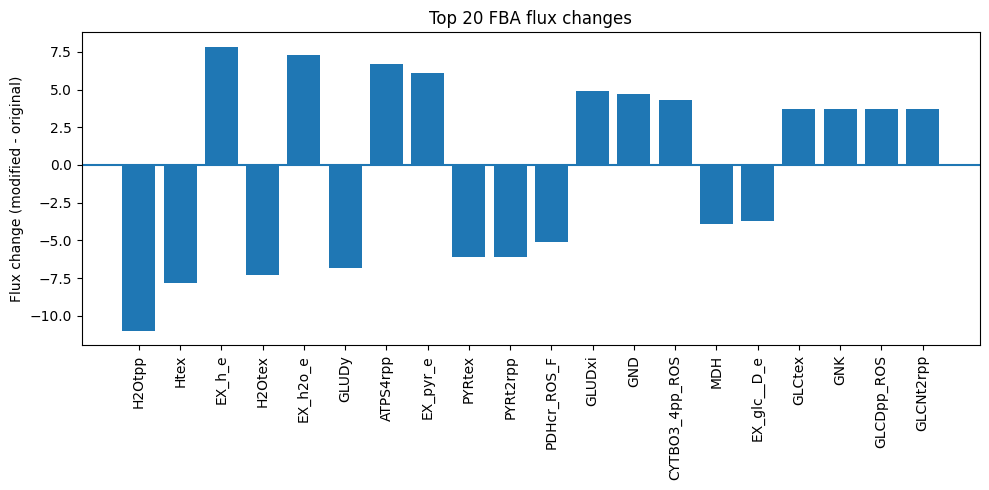

In [22]:
plot_fba_changes(df_comp)

In [23]:
# Compare FVAs
fva_comp = compare_fva(ROS_model, cons_model, ROS_reactions_list)

Infeasible: There is no optimal solution for the chosen objective! (infeasible).

The model is infeasible